In [1]:
# ! pip install tqdm yfinance quantstats

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import yfinance as yf
import pandas as pd

start = '2006-01-01'
end = '2024-01-01'

symbol = 'AAPL'

data = yf.download(symbol, start, end)
benchmark = data['Close']

[*********************100%%**********************]  1 of 1 completed


In [4]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,2.585000,2.669643,2.580357,2.669643,2.263003,807234400
2006-01-04,2.683214,2.713571,2.660714,2.677500,2.269662,619603600
2006-01-05,2.672500,2.675000,2.633929,2.656429,2.251801,449422400
2006-01-06,2.687500,2.739286,2.662500,2.725000,2.309927,704457600
2006-01-09,2.740357,2.757143,2.705000,2.716071,2.302358,675040800
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.600006,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,193.050003,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,193.149994,48087700


In [5]:
from btester import Strategy

def EMA(ser: pd.Series, period: int):
    return ser.ewm(span=period, adjust=False).mean().values

class MACrossoverStrategy(Strategy):
    def init(self, fast_period: int, slow_period: int):
        self.fast_ma = EMA(self.data['Close'], fast_period)
        self.slow_ma = EMA(self.data['Close'], slow_period)

    def next(self, i, record):
        if self.fast_ma[i-1] > self.slow_ma[i-1]:
            self.open(price=record['Open'])
        else:
            self.close(price=record['Open'])

In [6]:
from btester import Backtest
backtest = Backtest(MACrossoverStrategy, data, commission=.001, cash=1e6)

In [7]:
import quantstats as qs
from itertools import product
from tqdm.contrib.concurrent import process_map

parameters = ['Fast MA','Slow MA']
values = [[5, 10, 15, 20, 25], [30, 35, 40, 45, 50]]

def run(v):
    result = backtest.run(*v)
    returns = result.returns
    return [*v, returns.iloc[0], returns.iloc[-1], qs.stats.max_drawdown(returns) * 100, qs.stats.cagr(returns) * 100, qs.stats.sharpe(returns)]

optimization_results = process_map(run, list(product(*values)))
optimization_results = pd.DataFrame(optimization_results, columns=[*parameters,'Initial Capital','Cumulative Return','Max Drawdown (%)','CAGR (%)','Sharpe Ratio'])
optimization_results.set_index([*parameters], inplace=True)

100%|██████████| 25/25 [00:01<00:00, 16.15it/s]


In [8]:
optimization_results_sorted = optimization_results.sort_values('Sharpe Ratio', ascending=False)
optimization_results_sorted

Initial Capital  Cumulative Return  Max Drawdown (%)  \
Fast MA Slow MA                                                         
15      40          1.031712e+06       4.259749e+07        -32.368637   
5       30          1.031712e+06       3.331955e+07        -26.957375   
15      50          1.031712e+06       4.206925e+07        -31.849891   
        45          1.031712e+06       3.933729e+07        -29.853600   
20      30          1.031712e+06       3.677927e+07        -27.761538   
15      35          1.031712e+06       3.592651e+07        -30.693334   
25      35          1.031712e+06       3.904566e+07        -28.792054   
5       45          1.031712e+06       3.351782e+07        -28.950665   
        35          1.031712e+06       3.107334e+07        -26.041942   
10      45          1.031712e+06       3.447149e+07        -28.879571   
20      45          1.031712e+06       3.660443e+07        -27.593604   
        35          1.031712e+06       3.331321e+07        -32.471298   
        40          1.031712e+06       3.445833e+07        -30.539176   
5       40          1.031712e+06       2.973629e+07        -32.077388   
10      30          1.031712e+06       2.907231e+07        -27.930253   
        50          1.031712e+06       3.162149e+07        -34.680739   
25      40          1.031712e+06       3.351111e+07        -29.950521   
        30          1.031712e+06       2.831381e+07        -30.935617   
15      30          1.031712e+06       2.647738e+07        -28.246007   
20      50          1.031712e+06       3.052529e+07        -31.462612   
10      35          1.031712e+06       2.592967e+07        -28.847491   
25      45          1.031712e+06       2.913173e+07        -36.083784   
10      40          1.031712e+06       2.484586e+07        -29.274934   
25      50          1.031712e+06       2.768966e+07        -34.720589   
5       50          1.031712e+06       2.304413e+07        -28.449735   

                  CAGR (%)  Sharpe Ratio  
Fast MA Slow MA                           
15      40       15.341688      1.027992  
5       30       14.259852      1.010103  
15      50       15.286488      1.005542  
        45       14.989917      1.001510  
20      30       14.693693      1.001184  
15      35       14.590523      0.998207  
25      35       14.957096      0.986157  
5       45       14.285860      0.984059  
        35       13.954337      0.983252  
10      45       14.408928      0.978880  
20      45       14.672730      0.969251  
        35       14.259017      0.968217  
        40       14.407252      0.961070  
5       40       13.762230      0.959638  
10      30       13.663722      0.958044  
        50       14.030805      0.951926  
25      40       14.284982      0.947933  
        30       13.548508      0.927726  
15      30       13.256778      0.926014  
20      50       13.876573      0.923504  
10      35       13.165996      0.919874  
25      45       13.672625      0.910132  
10      40       12.980791      0.902522  
25      50       13.451452      0.890006  
5       50       12.654984      0.883666

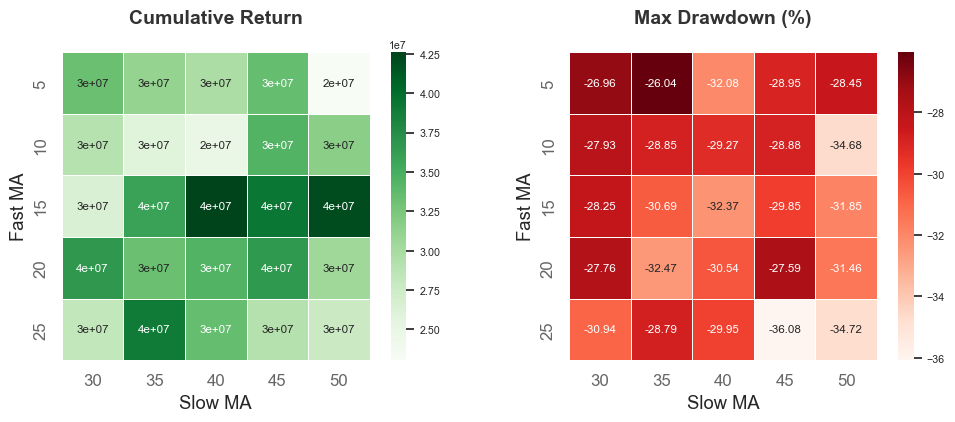

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].set_title('Cumulative Return\n', fontsize=14, fontweight='bold')
ax[1].set_title('Max Drawdown (%)\n', fontsize=14, fontweight='bold')

reshape = lambda d: pd.DataFrame(d.values.reshape(len(d.index.levels[0]), len(d.index.levels[1])), d.index.levels[0], d.index.levels[1])

sns.set(font_scale=.7)
sns.heatmap(reshape(optimization_results['Cumulative Return']), ax=ax[0], annot=True, fmt='.0g', linewidth=.5, square=True, cmap='Greens')
sns.heatmap(reshape(optimization_results['Max Drawdown (%)']), ax=ax[1], annot=True, fmt='.2f', linewidth=.5, square=True, cmap='Reds')

plt.show()

In [10]:
best_params = optimization_results_sorted.index[0]
best_params

(15, 40)

In [11]:
result = backtest.run(*best_params)

In [12]:
import quantstats as qs
qs.reports.metrics(result.returns, benchmark)

                    Benchmark      Strategy
------------------  -------------  ------------------------
Start Period        2006-01-03     2006-01-03
End Period          2023-12-29     2023-12-29
Risk-Free Rate      0.0%           0.0%
Time in Market      100.0%         100.0%

Cumulative Return   7,111.83%      -
CAGR﹪              17.84%         15.32%

Sharpe              0.9            1.03
Prob. Sharpe Ratio  99.99%         100.0%
Sortino             1.32           1.55
Sortino/√2          0.94           1.09
Omega               1.24           1.24

Max Drawdown        -60.87%        -
Longest DD Days     718            6494

Gain/Pain Ratio     0.18           0.24
Gain/Pain (1M)      1.0            1.28

Payoff Ratio        1.11           1.12
Profit Factor       1.18           -
Common Sense Ratio  1.25           1.39
CPC Index           0.69           0.73
Tail Ratio          1.07           35.86
Outlier Win Ratio   1489541139.59  1.56
Outlier Loss Ratio  -33411251.01   -

MTD 

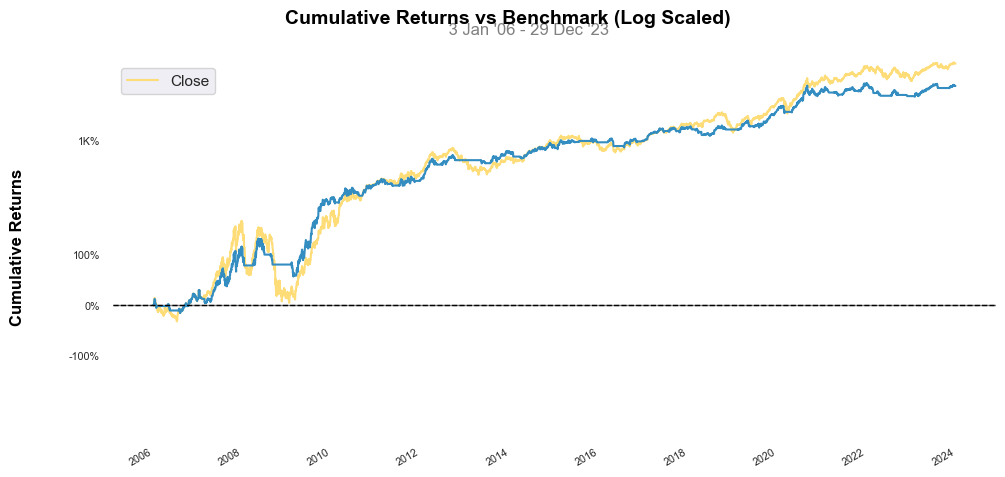

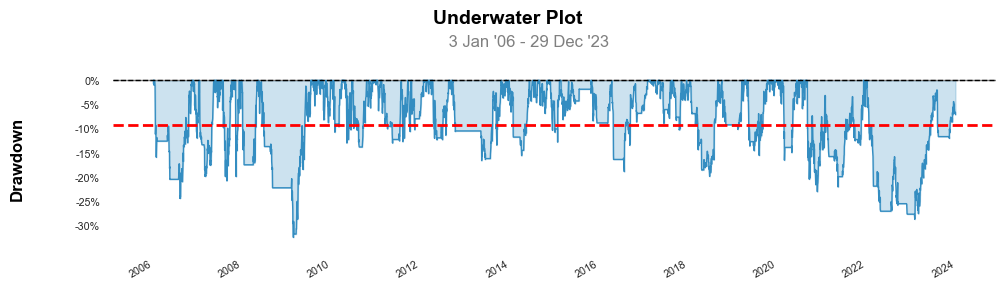

In [13]:
qs.plots.log_returns(result.returns, benchmark=benchmark)
qs.plots.drawdown(result.returns, figsize=(10,3))

In [14]:
trades = pd.DataFrame(result.trades)
trades.tail(15)

,symbol,open_date,close_date,open_price,close_price,position_size,profit_loss,change_pct,trade_commission,cumulative_return
36,None,2018-04-17,2018-04-24,44.122501,41.417500,314770.387239,-8.514545e+05,-6.130663,26925.459213,1.302397e+07
37,None,2018-05-07,2018-10-31,46.294998,54.220001,281044.495673,2.227278e+06,17.118487,28249.187311,1.522299e+07
38,None,2018-11-02,2018-11-05,52.387501,51.075001,290294.185774,-3.810111e+05,-2.505369,30034.562639,1.481195e+07
39,None,2019-02-11,2019-05-21,42.762501,46.305000,346031.021766,1.225815e+06,8.284126,30820.118401,1.600694e+07
40,None,2019-06-19,2020-03-02,49.919998,70.570000,320331.595269,6.614848e+06,41.366190,38596.753230,2.258319e+07
41,None,2020-04-27,2020-11-03,70.449997,109.660004,320236.126656,1.255646e+07,55.656506,57677.728967,3.508198e+07
42,None,2020-11-09,2021-02-25,120.500000,124.680000,290845.898724,1.215736e+06,3.468880,71309.597538,3.622640e+07
43,None,2021-04-12,2021-05-14,132.520004,126.250000,273092.459208,-1.712291e+06,-4.731364,70668.136836,3.444345e+07
44,None,2021-06-17,2021-09-29,129.800003,142.470001,265092.721164,3.358724e+06,9.761169,72176.796324,3.772999e+07
45,None,2021-10-22,2022-01-26,149.690002,163.500000,251802.389154,3.477390e+06,9.225731,78861.990874,4.112852e+07


In [15]:
open_positions = pd.DataFrame(result.open_positions)
open_positions

,symbol,open_date,last_date,open_price,last_price,position_size,profit_loss,change_pct,current_value
0,None,2023-11-09,2023-12-29,182.960007,192.529999,221251.181656,2.117372e+06,5.230647,4.259749e+07
